#### 01_DECISION_TREE_RANDOM_FOREST

Goal: Run a decision tree + random forest model and perform feature selection using RFE.

# 0) Import packages

In [1]:
# Generic packages
import warnings
import re

# Import ML Packages
import numpy as np
import scipy as sp
import sklearn as sk
import pandas as pd

# Import visualization packages
import matplotlib.pyplot as plt
import seaborn as sb

sklearn functions for feature selection

In [2]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, RFE, RFECV

sklearn functions for decision tree, random forest

In [3]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

Our own code

In [4]:
import importlib

In [5]:
import info5604_utils as util

This lets us reload the util functions if we change it, without restarting kernel

In [6]:
importlib.reload(util)

<module 'info5604_utils' from '/Users/abyb5152/Documents/GitHub/Applied-Machine-Learning/code/info5604_utils.py'>

# 1) Read the data

Increase the number of columns that can be displayed

In [7]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', None)

Read main dataset

In [8]:
lol_df = pd.read_csv("../clean_data/data.csv", header=[0,1],index_col=[0])
lol_df = lol_df[lol_df['golddiff','min_20'].notna()] #get rid of NA
lol_df = lol_df.fillna('No Ban') # Indicate where there was no ban
print(lol_df.shape)
lol_df.head()

(7578, 99)


Info                       \
                                             Address League  Year  Season   
0  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   
1  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   
2  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   
3  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   
4  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   

                                Blue                                 \
  GameType gamelength Winner TeamTag      Top  TopChamp      Jungle   
0   Season         40   Blue     TSM    Dyrus    Irelia    Santorin   
1   Season         38    Red     CST     Cris      Gnar     Impaler   
2   Season         40   Blue     WFX  Flaresz  Renekton  ShorterACE   
3   Season         41    Red     TIP     Rhux    Irelia        Rush   
4   Season         35   Blue     CLG    Benny      Gnar     Xmithie   

                                                                        \
  JungleChamp       Middle MiddleChamp         ADC  ADCChamp   Support   
0      RekSai     Bjergsen        Ahri  WildTurtle      Jinx   Lustboy   
1      Rengar        Jesiz        Ahri        Mash   Caitlyn     Sheep   
2      Rengar     Pobelter        Fizz       Altec     Sivir     Gleeb   
3    JarvanIV  XiaoWeiXiao     Leblanc      Apollo     Sivir    Adrian   
4    JarvanIV         Link   Lissandra  Doublelift  Tristana  aphromoo   

                   Red                                                  \
  SupportChamp TeamTag          Top TopChamp        Jungle JungleChamp   
0        Janna      C9        Balls     Gnar        Meteos       Elise   
1        Leona     DIG        Gamsu   Irelia       Crumbzz    JarvanIV   
2        Annie      GV     Hauntzer     Sion  Saintvicious      LeeSin   
3       Thresh      TL         Quas     Gnar    IWDominate        Nunu   
4        Janna      T8  CaliTrlolz8     Sion     Porpoise8      RekSai   

                                                                          \
     Middle MiddleChamp           ADC ADCChamp      Support SupportChamp   
0       Hai        Fizz        Sneaky    Sivir  LemonNation       Thresh   
1  Shiphtur        Azir        CoreJJ    Corki      KiWiKiD        Annie   
2     Keane        Azir           Cop    Corki   BunnyFuFuu        Janna   
3     Fenix        Lulu         KEITH   KogMaw      Xpecial        Janna   
4  Slooshi8        Lulu  Maplestreet8    Corki        Dodo8        Annie   

       Blue                                             Red                    \
      ban_1      ban_2      ban_3   ban_4   ban_5     ban_1    ban_2    ban_3   
0    Rumble   Kassadin  Lissandra  No Ban  No Ban  Tristana  Leblanc  Nidalee   
1  Kassadin      Sivir  Lissandra  No Ban  No Ban    RekSai    Janna  Leblanc   
2  JarvanIV  Lissandra   Kassadin  No Ban  No Ban   Leblanc      Zed   RekSai   
3     Annie  Lissandra   Kassadin  No Ban  No Ban    RekSai   Rumble   LeeSin   
4    Irelia   Pantheon   Kassadin  No Ban  No Ban    Rumble    Sivir   Rengar   

                  golddiff                       goldblue                \
    ban_4   ban_5    min_5 min_10 min_15  min_20    min_5 min_10 min_15   
0  No Ban  No Ban     -268   -625   -790  1422.0     5068  11361  18324   
1  No Ban  No Ban      147   -242   1394  1105.0     5511  11419  19698   
2  No Ban  No Ban       34    913   2922  5293.0     4933  12374  21237   
3  No Ban  No Ban      228     16   -335   768.0     5398  12033  19332   
4  No Ban  No Ban      113    205   -574   478.0     5404  11943  19426   

           goldred                        goldblueTop                        \
    min_20   min_5 min_10 min_15   min_20       min_5 min_10 min_15  min_20   
0  29519.0    5336  11986  19114  28097.0         893   2051   3630  6008.0   
1  27282.0    5364  11661  18304  26177.0        1127   2406   4594  6217.0   
2  31317.0    4899  11461  18

# 3) Decision tree classification

Set up the model. Note that the min-max scaling is unnecessary for decision tree/random forest, just good practice.

In [9]:
model = DecisionTreeClassifier(random_state=20220905)

Split training and test data with bResult as the target variable.

In [10]:
X_lol = lol_df.drop([('Info','Winner')], axis=1)
y_lol = lol_df[('Info','Winner')]

X_train, X_test, y_train, y_test = train_test_split(
    X_lol, y_lol, test_size=0.2, random_state=20220905, stratify=y_lol)

Set up column transformer: one-hot encoding for categorical vars, min-max scaling for numeric vars. Here we have to set handle unknowns to 'ignore' because there may be different unique champions in the test and training datasets.

In [11]:
CATEGORICAL_VARS=[('Info','League'), ('Info','Year'), ('Info','Season'), ('Info','GameType'), 
                  ('Blue', 'Top'), ('Blue','TopChamp'), ('Blue','Jungle'), ('Blue','JungleChamp'),
                  ('Blue','Middle'), ('Blue','MiddleChamp'), ('Blue', 'ADC'), ('Blue','ADCChamp'),
                  ('Blue', 'Support'), ('Blue', 'SupportChamp'), ('Blue', 'TeamTag'),
                  ( 'Red', 'Top'), ( 'Red','TopChamp'), ( 'Red','Jungle'), ( 'Red','JungleChamp'), 
                  ( 'Red','Middle'),( 'Red','MiddleChamp'), ( 'Red', 'ADC'), ( 'Red','ADCChamp'), 
                  ( 'Red', 'Support'),( 'Red', 'SupportChamp'), ( 'Red', 'TeamTag'), 
                  ('Blue', 'ban_1'), ('Blue', 'ban_2'), ('Blue', 'ban_3'), ('Blue', 'ban_4'), ('Blue', 'ban_5'),
                  ( 'Red', 'ban_1'), ( 'Red', 'ban_2'), ( 'Red', 'ban_3'), ( 'Red', 'ban_4'), ( 'Red', 'ban_5')]

NUMERIC_VARS=[('Info','gamelength'), 
              ('golddiff','min_5'),('golddiff','min_10'),('golddiff','min_15'),('golddiff','min_20'),
              ('goldblue','min_5'),('goldblue','min_10'),('goldblue','min_15'),('goldblue','min_20'),
              ('goldred','min_5'),('goldred','min_10'),('goldred','min_15'), ('goldred','min_20'),
              ('goldblueTop','min_5'),('goldblueTop','min_10'),('goldblueTop','min_15'),('goldblueTop','min_20'),
              ('goldblueJungle','min_5'),('goldblueJungle','min_10'),('goldblueJungle','min_15'),('goldblueJungle','min_20'),
              ('goldblueMiddle','min_5'),('goldblueMiddle','min_10'),('goldblueMiddle','min_15'),('goldblueMiddle','min_20'),
              ('goldblueADC','min_5'),('goldblueADC','min_10'),('goldblueADC','min_15'), ('goldblueADC','min_20'),
              ('goldblueSupport','min_5'),('goldblueSupport','min_10'), ('goldblueSupport','min_15'),('goldblueSupport','min_20'),
              ('goldredTop','min_5'),('goldredTop','min_10'),('goldredTop','min_15'),('goldredTop','min_20'),
              ('goldredJungle','min_5'),('goldredJungle','min_10'),('goldredJungle','min_15'),('goldredJungle','min_20'),
              ('goldredMiddle','min_5'),('goldredMiddle','min_10'),('goldredMiddle','min_15'),('goldredMiddle','min_20'),
              ('goldredADC','min_5'),('goldredADC','min_10'),('goldredADC','min_15'),('goldredADC','min_20'),
              ('goldredSupport','min_5'),('goldredSupport','min_10'),('goldredSupport','min_15'),('goldredSupport','min_20'),
              ('Blue','Towers'),('Red','Towers'),('Blue','Inhib'),('Red','Inhib'),('Blue','Kills'),('Red','Kills')]

ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

columns = ColumnTransformer([('category', ohe, CATEGORICAL_VARS), 
                             ('numeric', MinMaxScaler(), NUMERIC_VARS)],
                             remainder='drop')

Set up the pipeline for a grid search to look for the best parameters

In [12]:
selector = SelectKBest(score_func=chi2, k=20)

In [13]:
data_pipe = Pipeline(steps=[('preprocess', columns), ('filter', selector)])

In [14]:
pipe = Pipeline(steps=[('data',data_pipe), ('model', model)])

In [15]:
param_grid = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3,4,5,6,7,8],
    'model__min_samples_leaf': [2,3,4]
}

skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=20220914)

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=skf, verbose=2)

In [16]:
grid_search.fit(X_train, y_train)

Fitting 8 folds for each of 36 candidates, totalling 288 fits
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.3s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transf

[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=20220914, shuffle=True),
             estimator=Pipeline(steps=[('data',
                                        Pipeline(steps=[('preprocess',
                                                         ColumnTransformer(transformers=[('category',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'),
                                                                                          [('Info',
                                                                                            'League'),
                                                                                           ('Info',
                                                                                            'Year'),
                                                                                           ('Info',
                                                                                            'Season'),
                                                                                           ('Info',
                                                                                            'GameType'),
                                                                                           ('Blue',
                                                                                            'Top'),
                                                                                           ('Blue',
                                                                                            'TopChamp'),
                                                                                           ('B...
                                                                                            'min_10'),
                                                                                           ('goldblueADC',
                                                                                            'min_15'),
                                                                                           ('goldblueADC',
                                                                                            'min_20'),
                                                                                           ('goldblueSupport',
                                                                                            'min_5'), ...])])),
                                                        ('filter',
                                                         SelectKBest(k=20,
                                                                     score_func=<function chi2 at 0x139b828c0>))])),
                                       ('model',
                                        DecisionTreeClassifier(random_state=20220905))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [3, 4, 5, 6, 7, 8],
                         'model__min_samples_leaf': [2, 3, 4]},
             verbose=2)

In [17]:
params = grid_search.cv_results_['params']
scores = grid_search.cv_results_['mean_test_score']
rows = [dict(param_dict, score=score) for param_dict, score in zip(params, scores)]

In [18]:
rows

[{'model__criterion': 'gini',
  'model__max_depth': 3,
  'model__min_samples_leaf': 2,
  'score': 0.763443785878851},
 {'model__criterion': 'gini',
  'model__max_depth': 3,
  'model__min_samples_leaf': 3,
  'score': 0.763443785878851},
 {'model__criterion': 'gini',
  'model__max_depth': 3,
  'model__min_samples_leaf': 4,
  'score': 0.763443785878851},
 {'model__criterion': 'gini',
  'model__max_depth': 4,
  'model__min_samples_leaf': 2,
  'score': 0.7599809430364965},
 {'model__criterion': 'gini',
  'model__max_depth': 4,
  'model__min_samples_leaf': 3,
  'score': 0.7599809430364965},
 {'model__criterion': 'gini',
  'model__max_depth': 4,
  'model__min_samples_leaf': 4,
  'score': 0.7601458506882116},
 {'model__criterion': 'gini',
  'model__max_depth': 5,
  'model__min_samples_leaf': 2,
  'score': 0.7578358365022324},
 {'model__criterion': 'gini',
  'model__max_depth': 5,
  'model__min_samples_leaf': 3,
  'score': 0.758000526310286},
 {'model__criterion': 'gini',
  'model__max_depth': 

In [19]:
results_df = pd.DataFrame(rows)
results_df.columns = ['Criterion', 'Max Depth', 'Min Sample Leaf', 'Accuracy']
results_df.head()

,Criterion,Max Depth,Min Sample Leaf,Accuracy
0,gini,3,2,0.763444
1,gini,3,3,0.763444
2,gini,3,4,0.763444
3,gini,4,2,0.759981
4,gini,4,3,0.759981


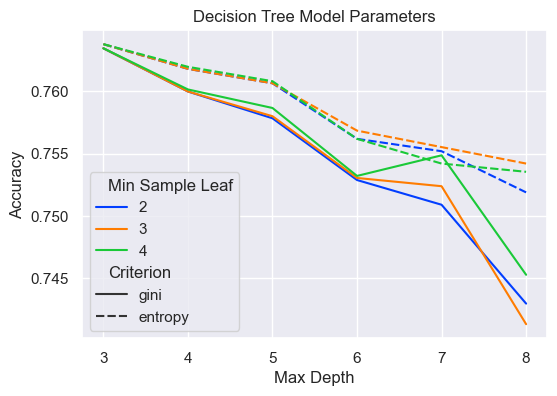

In [20]:
sb.set(rc={"figure.figsize":(6, 4)})
DT_Grid_plot = sb.lineplot(data=results_df, x='Max Depth', y='Accuracy',
                           hue='Min Sample Leaf', style = 'Criterion', palette = 'bright')
DT_Grid_plot.set(title = 'Decision Tree Model Parameters')
DT_Grid_plot.get_figure().savefig('../plots/DecisionTree_GridSearch_Combined.png', dpi=300, bbox_inches='tight')


In [21]:
results_df[results_df['Accuracy'] == max(results_df['Accuracy'])]

,Criterion,Max Depth,Min Sample Leaf,Accuracy
18,entropy,3,2,0.763774
19,entropy,3,3,0.763774
20,entropy,3,4,0.763774


With three different combinations of parameters, there are three different pssbile models to work with. The model with a max depth of 3 and minimum sample leaf of 4 will be the model continuing forward.

In [22]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf = 4, random_state=20220905)

In [23]:
pipe = Pipeline(steps=[('data',data_pipe), ('model', model)])

Compute cross-validation results for the decision tree. There will be warnings here and throughout because there are champions present in the test dataset that were not in the training dataset.

In [24]:
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=20220905)

scores = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='accuracy', verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10

[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.4s finished


Create a data frame from the scores

In [25]:
score_tree = pd.DataFrame({'score_tree': scores})
score_tree

,score_tree
0,0.782322
1,0.749340
2,0.766491
3,0.753298
4,0.770449
5,0.751979
6,0.772787
7,0.768824


Plot accuracy for each cross-validation run.

<AxesSubplot: >

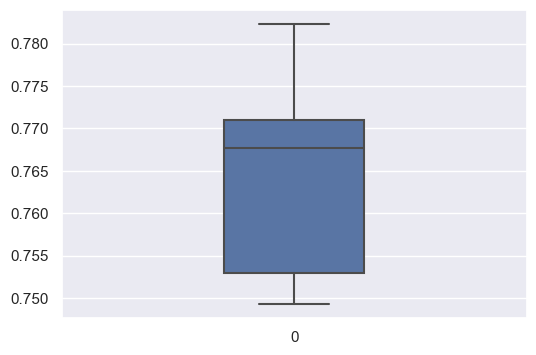

In [26]:
sb.boxplot(data=score_tree['score_tree'], width = 0.3)

Fit on all the training data

In [27]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('data',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(transformers=[('category',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   [('Info',
                                                                     'League'),
                                                                    ('Info',
                                                                     'Year'),
                                                                    ('Info',
                                                                     'Season'),
                                                                    ('Info',
                                                                     'GameType'),
                                                                    ('Blue',
                                                                     'Top'),
                                                                    ('Blue',
                                                                     'TopChamp'),
                                                                    ('Blue',
                                                                     'Jungle'),
                                                                    ('Blue',
                                                                     'JungleChamp'),
                                                                    ('Blue',
                                                                     'Middle'),
                                                                    ('Blue',
                                                                     'MiddleChamp'),
                                                                    ('Blue',
                                                                     'A...
                                                                     'min_15'),
                                                                    ('goldblueMiddle',
                                                                     'min_20'),
                                                                    ('goldblueADC',
                                                                     'min_5'),
                                                                    ('goldblueADC',
                                                                     'min_10'),
                                                                    ('goldblueADC',
                                                                     'min_15'),
                                                                    ('goldblueADC',
                                                                     'min_20'),
                                                                    ('goldblueSupport',
                                                                     'min_5'), ...])])),
                                 ('filter',
                                  SelectKBest(k=20,
                                              score_func=<function chi2 at 0x139b828c0>))])),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                        min_samples_leaf=4,
                                        random_state=20220905))])

Print accuracy on the training and test data

In [28]:
DT_acc_cmb = util.print_accuracies(pipe, X_train, y_train, X_test, y_test)

Train accuracy 0.766	Test accuracy 0.778


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


_Interpretation: for this very simple model, the accuracy is not great._

Show the relative importance of different features

In [29]:
feature_names = pipe.named_steps['data'].get_feature_names_out()
feature_coefs = pipe.named_steps['model'].feature_importances_
feature_df = pd.DataFrame({'Feature Name': list(feature_names), 'Importance': list(feature_coefs.flatten())})
feature_df.sort_values(by='Importance', axis=0, ascending=False, inplace=True, ignore_index=True)
#feature_df['feature'].replace(to_replace=['numeric__','category__','ABBREVIATION_'], value='', regex=True, inplace=True)
feature_df.head(20)

,Feature Name,Importance
0,numeric__x41,1.0
1,category__x13_Bang,0.0
2,numeric__x45,0.0
3,numeric__x94,0.0
4,numeric__x91,0.0
5,numeric__x90,0.0
6,numeric__x81,0.0
7,numeric__x77,0.0
8,numeric__x49,0.0
9,numeric__x48,0.0


In [30]:
X_cols = pd.DataFrame(X_lol.columns, columns=['column'])
X_cols['column'] = X_cols['column'].astype(str)
X_cols['col'] = np.linspace(0, len(X_lol.columns)-1, num=len(X_lol.columns)).astype(int).astype(str)
X_cols = dict(zip(X_cols.col, X_cols.column))
X_cols

{'0': "('Info', 'Address')",
 '1': "('Info', 'League')",
 '2': "('Info', 'Year')",
 '3': "('Info', 'Season')",
 '4': "('Info', 'GameType')",
 '5': "('Info', 'gamelength')",
 '6': "('Blue', 'TeamTag')",
 '7': "('Blue', 'Top')",
 '8': "('Blue', 'TopChamp')",
 '9': "('Blue', 'Jungle')",
 '10': "('Blue', 'JungleChamp')",
 '11': "('Blue', 'Middle')",
 '12': "('Blue', 'MiddleChamp')",
 '13': "('Blue', 'ADC')",
 '14': "('Blue', 'ADCChamp')",
 '15': "('Blue', 'Support')",
 '16': "('Blue', 'SupportChamp')",
 '17': "('Red', 'TeamTag')",
 '18': "('Red', 'Top')",
 '19': "('Red', 'TopChamp')",
 '20': "('Red', 'Jungle')",
 '21': "('Red', 'JungleChamp')",
 '22': "('Red', 'Middle')",
 '23': "('Red', 'MiddleChamp')",
 '24': "('Red', 'ADC')",
 '25': "('Red', 'ADCChamp')",
 '26': "('Red', 'Support')",
 '27': "('Red', 'SupportChamp')",
 '28': "('Blue', 'ban_1')",
 '29': "('Blue', 'ban_2')",
 '30': "('Blue', 'ban_3')",
 '31': "('Blue', 'ban_4')",
 '32': "('Blue', 'ban_5')",
 '33': "('Red', 'ban_1')",
 '34'

In [31]:
list_of_chars=['\(', '\)', '\'']
pattern = '[' +  ''.join(list_of_chars) +  ']'
feature_df['Feature Name 2'] = [ re.sub(', ', '_', re.sub(pattern, '', re.sub('(.*)__x(\d+)',X_cols.get(re.search('x(\d+)', s).group(1)),s))) for s in feature_df['Feature Name']]
feature_df

,Feature Name,Importance,Feature Name 2
0,numeric__x41,1.0,golddiff_min_20
1,category__x13_Bang,0.0,Blue_ADC_Bang
2,numeric__x45,0.0,goldblue_min_20
3,numeric__x94,0.0,Blue_Kills
4,numeric__x91,0.0,Red_Towers
5,numeric__x90,0.0,Blue_Towers
6,numeric__x81,0.0,goldredMiddle_min_20
7,numeric__x77,0.0,goldredJungle_min_20
8,numeric__x49,0.0,goldred_min_20
9,numeric__x48,0.0,goldred_min_15


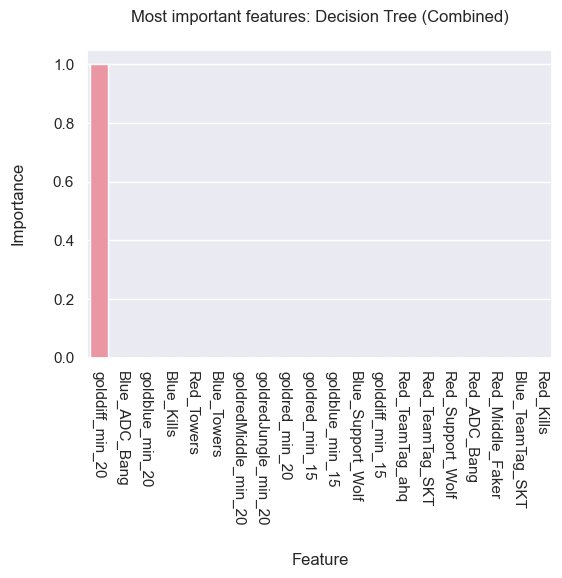

In [32]:
ax = sb.barplot(data=feature_df.iloc[0:20], x='Feature Name 2', y='Importance', orient='v')
ax.tick_params(axis='x', rotation=270)
ax.set_ylabel('Importance', rotation=90, labelpad=20)
ax.set_xlabel('Feature', rotation=0, labelpad=20)
ax.set_title('Most important features: Decision Tree (Combined)', pad=20)
plt.savefig('../plots/DecisionTree_importances_combined.pdf',dpi=300, bbox_inches = "tight")

Plot the decision tree. Go left if the condition is true, else go right.

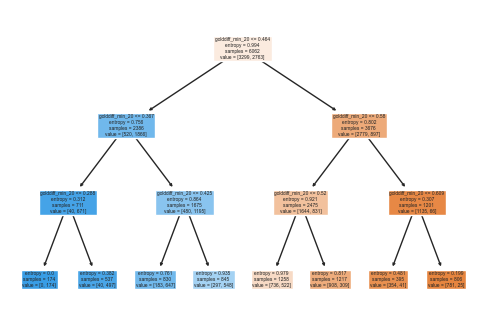

In [33]:
plot_tree(model, filled=True, feature_names = [ re.sub(', ', '_', re.sub(pattern, '', re.sub('(.*)__x(\d+)',X_cols.get(re.search('x(\d+)', s).group(1)),s))) for s in list(pipe.named_steps['data'].get_feature_names_out())])
plt.savefig('../plots/tree_combined.pdf')

_Interpretation: the first few levels of the tree overwhelmingly split on gold difference at 10 minutes and game length._

# 4) Random forest classification

Set up the model

In [34]:
RFC = RandomForestClassifier(random_state=20220929)

Set up the pipeline for grid search

In [35]:
pipe_RFC = Pipeline(steps=[('data',data_pipe), ('model', RFC)])

In [36]:
param_grid = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3,4,5,6,7,8],
    'model__min_samples_leaf': [2,3,4],
}

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=skf, verbose=2)

In [37]:
grid_search.fit(X_train, y_train)

Fitting 8 folds for each of 36 candidates, totalling 288 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform

[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=20220905, shuffle=True),
             estimator=Pipeline(steps=[('data',
                                        Pipeline(steps=[('preprocess',
                                                         ColumnTransformer(transformers=[('category',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'),
                                                                                          [('Info',
                                                                                            'League'),
                                                                                           ('Info',
                                                                                            'Year'),
                                                                                           ('Info',
                                                                                            'Season'),
                                                                                           ('Info',
                                                                                            'GameType'),
                                                                                           ('Blue',
                                                                                            'Top'),
                                                                                           ('Blue',
                                                                                            'TopChamp'),
                                                                                           ('B...
                                                                                            'min_20'),
                                                                                           ('goldblueSupport',
                                                                                            'min_5'), ...])])),
                                                        ('filter',
                                                         SelectKBest(k=20,
                                                                     score_func=<function chi2 at 0x139b828c0>))])),
                                       ('model',
                                        DecisionTreeClassifier(criterion='entropy',
                                                               max_depth=3,
                                                               min_samples_leaf=4,
                                                               random_state=20220905))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [3, 4, 5, 6, 7, 8],
                         'model__min_samples_leaf': [2, 3, 4]},
             verbose=2)

In [38]:
params = grid_search.cv_results_['params']
scores = grid_search.cv_results_['mean_test_score']
rows = [dict(param_dict, score=score) for param_dict, score in zip(params, scores)]

In [39]:
rows

[{'model__criterion': 'gini',
  'model__max_depth': 3,
  'model__min_samples_leaf': 2,
  'score': 0.7650967835819075},
 {'model__criterion': 'gini',
  'model__max_depth': 3,
  'model__min_samples_leaf': 3,
  'score': 0.7650967835819075},
 {'model__criterion': 'gini',
  'model__max_depth': 3,
  'model__min_samples_leaf': 4,
  'score': 0.7650967835819075},
 {'model__criterion': 'gini',
  'model__max_depth': 4,
  'model__min_samples_leaf': 2,
  'score': 0.761797759172961},
 {'model__criterion': 'gini',
  'model__max_depth': 4,
  'model__min_samples_leaf': 3,
  'score': 0.7611381285661007},
 {'model__criterion': 'gini',
  'model__max_depth': 4,
  'model__min_samples_leaf': 4,
  'score': 0.7613030362178158},
 {'model__criterion': 'gini',
  'model__max_depth': 5,
  'model__min_samples_leaf': 2,
  'score': 0.7558604301802352},
 {'model__criterion': 'gini',
  'model__max_depth': 5,
  'model__min_samples_leaf': 3,
  'score': 0.75503589192166},
 {'model__criterion': 'gini',
  'model__max_depth':

In [40]:
results_df = pd.DataFrame(rows)
results_df.columns = ['Criterion', 'Max Depth', 'Min Sample Leaf','Accuracy']
results_df.head()

,Criterion,Max Depth,Min Sample Leaf,Accuracy
0,gini,3,2,0.765097
1,gini,3,3,0.765097
2,gini,3,4,0.765097
3,gini,4,2,0.761798
4,gini,4,3,0.761138


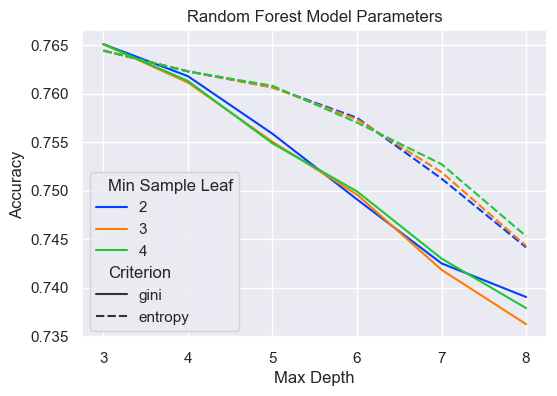

In [41]:
RFC_Grid_plot = sb.lineplot(data=results_df, x='Max Depth', y='Accuracy',
                           hue = 'Min Sample Leaf', style = 'Criterion', palette = 'bright')
RFC_Grid_plot.set(title = 'Random Forest Model Parameters')
RFC_Grid_plot.get_figure().savefig('../plots/RandomForest_GridSearch_Combined.png', dpi=300, bbox_inches='tight')

In [42]:
results_df[results_df['Accuracy'] == max(results_df['Accuracy'])]

,Criterion,Max Depth,Min Sample Leaf,Accuracy
0,gini,3,2,0.765097
1,gini,3,3,0.765097
2,gini,3,4,0.765097


Same results as the desision tree. The model parameters going forward will be max depth of 4 and minimum sample leaf of 4.

In [43]:
RFC = RandomForestClassifier(max_depth=3, criterion='gini', min_samples_leaf = 4,random_state=20220929)

In [44]:
pipe_RFC = Pipeline(steps=[('data',data_pipe), ('model', RFC)])

Compute cross-validation results for the random forest

In [45]:
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=20220905)

scores = cross_val_score(pipe_RFC, X_train, y_train, cv=skf, scoring='accuracy', verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .................................................... total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.2s finished


Create a data frame from the scores

In [46]:
score_RFC = pd.DataFrame({'score_RFC': scores})
score_RFC

,score_RFC
0,0.774406
1,0.751979
2,0.766491
3,0.753298
4,0.775726
5,0.749340
6,0.770145
7,0.766182


Plot accuracy for each cross-validation run.

<AxesSubplot: >

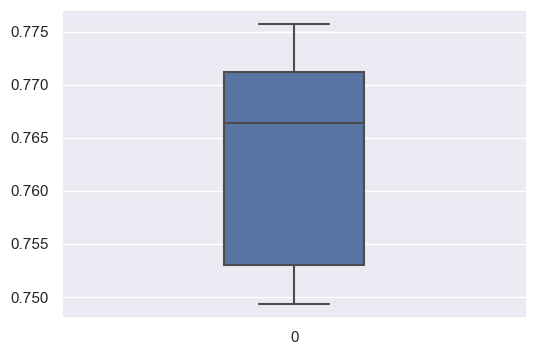

In [47]:
sb.boxplot(data=score_RFC['score_RFC'], width = 0.3)

Fit on all the training data

In [48]:
pipe_RFC.fit(X_train,y_train)

Pipeline(steps=[('data',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(transformers=[('category',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   [('Info',
                                                                     'League'),
                                                                    ('Info',
                                                                     'Year'),
                                                                    ('Info',
                                                                     'Season'),
                                                                    ('Info',
                                                                     'GameType'),
                                                                    ('Blue',
                                                                     'Top'),
                                                                    ('Blue',
                                                                     'TopChamp'),
                                                                    ('Blue',
                                                                     'Jungle'),
                                                                    ('Blue',
                                                                     'JungleChamp'),
                                                                    ('Blue',
                                                                     'Middle'),
                                                                    ('Blue',
                                                                     'MiddleChamp'),
                                                                    ('Blue',
                                                                     'A...
                                                                    ('goldblueMiddle',
                                                                     'min_15'),
                                                                    ('goldblueMiddle',
                                                                     'min_20'),
                                                                    ('goldblueADC',
                                                                     'min_5'),
                                                                    ('goldblueADC',
                                                                     'min_10'),
                                                                    ('goldblueADC',
                                                                     'min_15'),
                                                                    ('goldblueADC',
                                                                     'min_20'),
                                                                    ('goldblueSupport',
                                                                     'min_5'), ...])])),
                                 ('filter',
                                  SelectKBest(k=20,
                                              score_func=<function chi2 at 0x139b828c0>))])),
                ('model',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=4,
                                        random_state=20220929))])

Print accuracy on the training and test data

In [49]:
RFC_acc_cmb = util.print_accuracies(pipe_RFC, X_train, y_train, X_test, y_test)

Train accuracy 0.768	Test accuracy 0.782


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [50]:
feature_names = pipe_RFC.named_steps['data'].get_feature_names_out()
feature_coefs = pipe_RFC.named_steps['model'].feature_importances_
feature_df = pd.DataFrame({'Feature Name': list(feature_names), 'Importance': list(feature_coefs.flatten())})
feature_df.sort_values(by='Importance', axis=0, ascending=False, inplace=True, ignore_index=True)
#feature_df['feature'].replace(to_replace=['numeric__','category__','ABBREVIATION_'], value='', regex=True, inplace=True)
feature_df.head(20)

,Feature Name,Importance
0,numeric__x41,0.332597
1,numeric__x40,0.214533
2,numeric__x49,0.134694
3,numeric__x45,0.090170
4,numeric__x90,0.049233
5,numeric__x81,0.037831
6,numeric__x91,0.034170
7,numeric__x44,0.026591
8,numeric__x48,0.025239
9,numeric__x95,0.022562


In [51]:
X_cols = pd.DataFrame(X_lol.columns, columns=['column'])
X_cols['column'] = X_cols['column'].astype(str)
X_cols['col'] = np.linspace(0, len(X_lol.columns)-1, num=len(X_lol.columns)).astype(int).astype(str)
X_cols = dict(zip(X_cols.col, X_cols.column))
X_cols

{'0': "('Info', 'Address')",
 '1': "('Info', 'League')",
 '2': "('Info', 'Year')",
 '3': "('Info', 'Season')",
 '4': "('Info', 'GameType')",
 '5': "('Info', 'gamelength')",
 '6': "('Blue', 'TeamTag')",
 '7': "('Blue', 'Top')",
 '8': "('Blue', 'TopChamp')",
 '9': "('Blue', 'Jungle')",
 '10': "('Blue', 'JungleChamp')",
 '11': "('Blue', 'Middle')",
 '12': "('Blue', 'MiddleChamp')",
 '13': "('Blue', 'ADC')",
 '14': "('Blue', 'ADCChamp')",
 '15': "('Blue', 'Support')",
 '16': "('Blue', 'SupportChamp')",
 '17': "('Red', 'TeamTag')",
 '18': "('Red', 'Top')",
 '19': "('Red', 'TopChamp')",
 '20': "('Red', 'Jungle')",
 '21': "('Red', 'JungleChamp')",
 '22': "('Red', 'Middle')",
 '23': "('Red', 'MiddleChamp')",
 '24': "('Red', 'ADC')",
 '25': "('Red', 'ADCChamp')",
 '26': "('Red', 'Support')",
 '27': "('Red', 'SupportChamp')",
 '28': "('Blue', 'ban_1')",
 '29': "('Blue', 'ban_2')",
 '30': "('Blue', 'ban_3')",
 '31': "('Blue', 'ban_4')",
 '32': "('Blue', 'ban_5')",
 '33': "('Red', 'ban_1')",
 '34'

In [52]:
list_of_chars=['\(', '\)', '\'']
pattern = '[' +  ''.join(list_of_chars) +  ']'
feature_df['Feature Name 2'] = [ re.sub(', ', '_', re.sub(pattern, '', re.sub('(.*)__x(\d+)',X_cols.get(re.search('x(\d+)', s).group(1)),s))) for s in feature_df['Feature Name']]
feature_df

,Feature Name,Importance,Feature Name 2
0,numeric__x41,0.332597,golddiff_min_20
1,numeric__x40,0.214533,golddiff_min_15
2,numeric__x49,0.134694,goldred_min_20
3,numeric__x45,0.090170,goldblue_min_20
4,numeric__x90,0.049233,Blue_Towers
5,numeric__x81,0.037831,goldredMiddle_min_20
6,numeric__x91,0.034170,Red_Towers
7,numeric__x44,0.026591,goldblue_min_15
8,numeric__x48,0.025239,goldred_min_15
9,numeric__x95,0.022562,Red_Kills


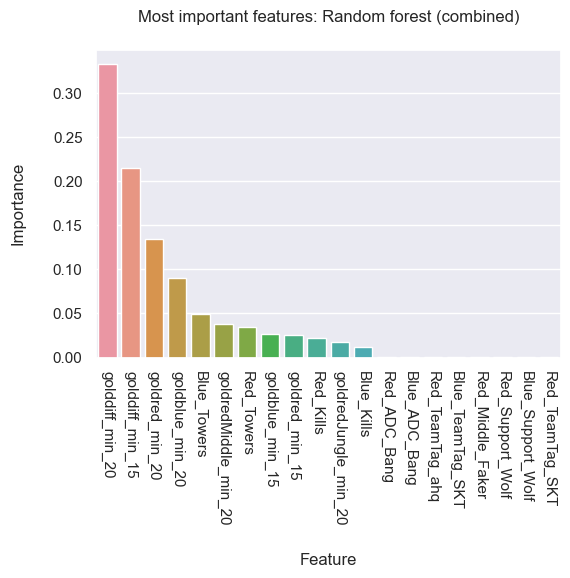

In [53]:
ax = sb.barplot(data=feature_df.iloc[0:20], x='Feature Name 2', y='Importance', orient='v')
ax.tick_params(axis='x', rotation=270)
ax.set_ylabel('Importance', rotation=90, labelpad=20)
ax.set_xlabel('Feature', rotation=0, labelpad=20)
ax.set_title('Most important features: Random forest (combined)', pad=20)
plt.savefig('../plots/RandomForest_importances_combined.pdf',dpi=300, bbox_inches = "tight")

_Once again we see that the gold difference related features are the most important features_

# Generalizing the model to predict outcome with just a singel team's stats, instead using team vs team data.

The general idea is here is to see how accurate the model is looking at the stats of one team instead of team vs team like above. The trade off here is that there is more data for the models to learn from, but some context is lost to the model. We now have each team on a seperate row and a column to indicate which team we are looking at.

In [54]:
blue = lol_df['Blue'].copy()
blue['Team'] = 'Blue'

red = lol_df['Red'].copy()
red['Team'] = 'Red'

info = lol_df['Info'].copy()

Code below is for seperating the features with the same name across the teams. For example, ADC gold is a feature twice once for blue team and once for red team.

In [55]:
diff = lol_df['golddiff'].copy()
diff.columns = ['Diff 5','Diff 10','Diff 15','Diff 20']
info = pd.concat([info,diff], axis=1)

gold = lol_df['goldred'].copy()
gold.columns = ['Team 5','Team 10','Team 15','Team 20']
red = pd.concat([red,gold], axis=1)

gold = lol_df['goldblue'].copy()
gold.columns = ['Team 5','Team 10','Team 15','Team 20']
blue = pd.concat([blue,gold], axis=1)

In [56]:
goldcol = ['goldblueTop','goldblueJungle','goldblueADC','goldblueSupport','goldblueMiddle',
          'goldredTop','goldredJungle','goldredADC','goldredSupport','goldredMiddle']

for i in goldcol:
    gold = lol_df[i]
    if i[4:7] == 'red':
        gold.columns = [i[7:]+' 5',i[7:]+' 10',i[7:]+' 15',i[7:]+' 20']
        red = pd.concat([red,gold], axis=1)
    elif i[4:8] == 'blue':
        gold.columns = [i[8:]+' 5',i[8:]+' 10',i[8:]+' 15',i[8:]+' 20']
        blue = pd.concat([blue,gold], axis=1)

In [57]:
blue = pd.concat([info,blue], axis=1)
red = pd.concat([info,red], axis=1)

lol_df2 = pd.concat([blue,red],axis=0)

In [58]:
lol_df2.head()

,Address,League,Year,Season,GameType,gamelength,Winner,FirstBlood,FirstTower,Diff 5,Diff 10,Diff 15,Diff 20,TeamTag,Top,TopChamp,Jungle,JungleChamp,Middle,MiddleChamp,ADC,ADCChamp,Support,SupportChamp,ban_1,ban_2,ban_3,ban_4,ban_5,Towers,Inhib,Kills,Team,Team 5,Team 10,Team 15,Team 20,Top 5,Top 10,Top 15,Top 20,Jungle 5,Jungle 10,Jungle 15,Jungle 20,ADC 5,ADC 10,ADC 15,ADC 20,Support 5,Support 10,Support 15,Support 20,Middle 5,Middle 10,Middle 15,Middle 20
0,http://matchhistory.na.leagueoflegends.com/en/...,NALCS,2015,Spring,Season,40,Blue,Blue,Blue,-268,-625,-790,1422.0,TSM,Dyrus,Irelia,Santorin,RekSai,Bjergsen,Ahri,WildTurtle,Jinx,Lustboy,Janna,Rumble,Kassadin,Lissandra,No Ban,No Ban,4.0,0.0,4.0,Blue,5068,11361,18324,29519.0,893,2051,3630,6008.0,1049,2486,3632,5799.0,1127,2495,4051,6359.0,897,1666,2403,4045.0,1102,2663,4608,7308.0
1,http://matchhistory.na.leagueoflegends.com/en/...,NALCS,2015,Spring,Season,38,Red,Blue,Red,147,-242,1394,1105.0,CST,Cris,Gnar,Impaler,Rengar,Jesiz,Ahri,Mash,Caitlyn,Sheep,Leona,Kassadin,Sivir,Lissandra,No Ban,No Ban,1.0,0.0,5.0,Blue,5511,11419,19698,27282.0,1127,2406,4594,6217.0,1176,2350,3929,5205.0,1182,2415,3869,5695.0,924,1701,2757,3824.0,1102,2547,4549,6341.0
2,http://matchhistory.na.leagueoflegends.com/en/...,NALCS,2015,Spring,Season,40,Blue,Blue,Blue,34,913,2922,5293.0,WFX,Flaresz,Renekton,ShorterACE,Rengar,Pobelter,Fizz,Altec,Sivir,Gleeb,Annie,JarvanIV,Lissandra,Kassadin,No Ban,No Ban,3.0,0.0,11.0,Blue,4933,12374,21237,31317.0,828,2419,4187,6478.0,1041,2552,4026,5321.0,1130,2723,4899,7580.0,869,1815,3264,5161.0,1065,2865,4861,6777.0
3,http://matchhistory.na.leagueoflegends.com/en/...,NALCS,2015,Spring,Season,41,Red,Red,Blue,228,16,-335,768.0,TIP,Rhux,Irelia,Rush,JarvanIV,XiaoWeiXiao,Leblanc,Apollo,Sivir,Adrian,Thresh,Annie,Lissandra,Kassadin,No Ban,No Ban,2.0,0.0,5.0,Blue,5398,12033,19332,25772.0,992,2662,4296,5544.0,1272,2390,3627,4867.0,1202,2756,4555,6305.0,866,1692,2476,3334.0,1066,2533,4378,5722.0
4,http://matchhistory.na.leagueoflegends.com/en/...,NALCS,2015,Spring,Season,35,Blue,Blue,Red,113,205,-574,478.0,CLG,Benny,Gnar,Xmithie,JarvanIV,Link,Lissandra,Doublelift,Tristana,aphromoo,Janna,Irelia,Pantheon,Kassadin,No Ban,No Ban,2.0,0.0,1.0,Blue,5404,11943,19426,27472.0,1038,2446,4020,5920.0,1174,2272,3696,5154.0,1203,2907,4933,6675.0,877,1675,2620,3720.0,1112,2643,4157,6003.0


In [59]:
y = lol_df2['Winner']
X = lol_df2.drop(['Winner','Address'],axis=1)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20220905, stratify=y)

In [61]:
X.columns

Index(['League', 'Year', 'Season', 'GameType', 'gamelength', 'FirstBlood',
       'FirstTower', 'Diff 5', 'Diff 10', 'Diff 15', 'Diff 20', 'TeamTag',
       'Top', 'TopChamp', 'Jungle', 'JungleChamp', 'Middle', 'MiddleChamp',
       'ADC', 'ADCChamp', 'Support', 'SupportChamp', 'ban_1', 'ban_2', 'ban_3',
       'ban_4', 'ban_5', 'Towers', 'Inhib', 'Kills', 'Team', 'Team 5',
       'Team 10', 'Team 15', 'Team 20', 'Top 5', 'Top 10', 'Top 15', 'Top 20',
       'Jungle 5', 'Jungle 10', 'Jungle 15', 'Jungle 20', 'ADC 5', 'ADC 10',
       'ADC 15', 'ADC 20', 'Support 5', 'Support 10', 'Support 15',
       'Support 20', 'Middle 5', 'Middle 10', 'Middle 15', 'Middle 20'],
      dtype='object')

# 3) Decision tree classification, Separate red/blue

Set up the model. Note that the min-max scaling is unnecessary for decision tree/random forest, just good practice.

In [146]:
model = DecisionTreeClassifier(random_state=20220905)

Set up column transformer: one-hot encoding for categorical vars, min-max scaling for numeric vars. Here we have to set handle unknowns to 'ignore' because there may be different unique champions in the test and training datasets.

In [147]:
CATEGORICAL_VARS=['League', 'Season', 'GameType',
                  'TeamTag', 'Top', 'TopChamp', 'Jungle', 'JungleChamp', 'Middle', 'MiddleChamp',
                   'ADC', 'ADCChamp', 'Support', 'SupportChamp', 'ban_1', 'ban_2', 'ban_3',
                   'ban_4', 'ban_5', 'Team']

NUMERIC_VARS=['gamelength','Year',
              'Towers', 'Inhib', 'Kills', 'Team 5',
               'Team 10', 'Team 15', 'Team 20', 'Top 5', 'Top 10', 'Top 15', 'Top 20',
               'Jungle 5', 'Jungle 10', 'Jungle 15', 'Jungle 20', 'ADC 5', 'ADC 10',
               'ADC 15', 'ADC 20', 'Support 5', 'Support 10', 'Support 15',
               'Support 20', 'Middle 5', 'Middle 10', 'Middle 15', 'Middle 20']

ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

columns = ColumnTransformer([('category', ohe, CATEGORICAL_VARS), 
                             ('numeric', MinMaxScaler(), NUMERIC_VARS)],
                             remainder='drop')

Set up the pipeline for grid search

In [148]:
selector = SelectKBest(score_func=chi2, k=20)

In [149]:
data_pipe = Pipeline(steps=[('preprocess', columns), ('filter', selector)])

In [150]:
pipe = Pipeline(steps=[('data',data_pipe), ('model', model)])

In [151]:
param_grid = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3,4,5,6,7,8],
    'model__min_samples_leaf': [2,3,4]
}

skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=20220914)

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=skf, verbose=2)

In [152]:
grid_search.fit(X_train, y_train)

Fitting 8 folds for each of 36 candidates, totalling 288 fits
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.1s


GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=20220914, shuffle=True),
             estimator=Pipeline(steps=[('data',
                                        Pipeline(steps=[('preprocess',
                                                         ColumnTransformer(transformers=[('category',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'),
                                                                                          ['League',
                                                                                           'Season',
                                                                                           'GameType',
                                                                                           'TeamTag',
                                                                                           'Top',
                                                                                           'TopChamp',
                                                                                           'Jungle',
                                                                                           'JungleChamp',
                                                                                           'Middle',
                                                                                           'MiddleChamp',
                                                                                           'ADC',
                                                                                           'A...
                                                                                           'Support '
                                                                                           '10',
                                                                                           'Support '
                                                                                           '15',
                                                                                           'Support '
                                                                                           '20',
                                                                                           'Middle '
                                                                                           '5',
                                                                                           'Middle '
                                                                                           '10',
                                                                                           'Middle '
                                                                                           '15',
                                                                                           'Middle '
                                                                                           '20'])])),
                                                        ('filter',
                                                         SelectKBest(k=20,
                                                                     score_func=<function chi2 at 0x139b828c0>))])),
                                       ('model',
                                        DecisionTreeClassifier(random_state=20220905))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [3, 4, 5, 6, 7, 8],
                         'model__min_samples_leaf': [2, 3, 4]},
             verbose=2)

In [153]:
params = grid_search.cv_results_['params']
scores = grid_search.cv_results_['mean_test_score']
rows = [dict(param_dict, score=score) for param_dict, score in zip(params, scores)]

In [154]:
rows

[{'model__criterion': 'gini',
  'model__max_depth': 3,
  'model__min_samples_leaf': 2,
  'score': 0.5439620396736243},
 {'model__criterion': 'gini',
  'model__max_depth': 3,
  'model__min_samples_leaf': 3,
  'score': 0.5440444934994819},
 {'model__criterion': 'gini',
  'model__max_depth': 3,
  'model__min_samples_leaf': 4,
  'score': 0.5442918549770543},
 {'model__criterion': 'gini',
  'model__max_depth': 4,
  'model__min_samples_leaf': 2,
  'score': 0.5435496616944017},
 {'model__criterion': 'gini',
  'model__max_depth': 4,
  'model__min_samples_leaf': 3,
  'score': 0.5436321155202591},
 {'model__criterion': 'gini',
  'model__max_depth': 4,
  'model__min_samples_leaf': 4,
  'score': 0.5437970775969417},
 {'model__criterion': 'gini',
  'model__max_depth': 5,
  'model__min_samples_leaf': 2,
  'score': 0.5432197375410364},
 {'model__criterion': 'gini',
  'model__max_depth': 5,
  'model__min_samples_leaf': 3,
  'score': 0.5432197375410364},
 {'model__criterion': 'gini',
  'model__max_dept

In [155]:
results_df = pd.DataFrame(rows)
results_df.columns = ['Criterion', 'Max Depth', 'Min Sample Leaf', 'Accuracy']
results_df.head()

,Criterion,Max Depth,Min Sample Leaf,Accuracy
0,gini,3,2,0.543962
1,gini,3,3,0.544044
2,gini,3,4,0.544292
3,gini,4,2,0.543550
4,gini,4,3,0.543632


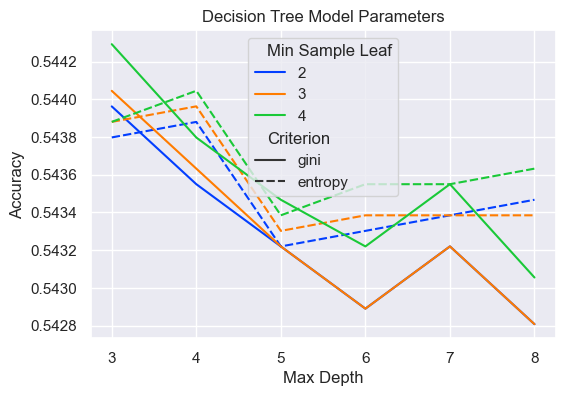

In [156]:
sb.set(rc={"figure.figsize":(6, 4)})
DT_Grid_plot = sb.lineplot(data=results_df, x='Max Depth', y='Accuracy',
                           hue='Min Sample Leaf', style = 'Criterion', palette = 'bright')
DT_Grid_plot.set(title = 'Decision Tree Model Parameters')
DT_Grid_plot.get_figure().savefig('../plots/DecisionTree_GridSearch_Separated.png', dpi=300, bbox_inches='tight')

In [157]:
results_df[results_df['Accuracy'] == max(results_df['Accuracy'])]

,Criterion,Max Depth,Min Sample Leaf,Accuracy
2,gini,3,4,0.544292


Best model parameters are Gini as the criterion, max depth at 3, and min sample leaf at 4. Also it is important to take note that the best accuracy is lower compared the decision tree model above.

In [158]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf = 4, random_state=20220905)

In [159]:
pipe = Pipeline(steps=[('data',data_pipe), ('model', model)])

Compute cross-validation results for the decision tree. There will be warnings here and throughout because there are champions present in the test dataset that were not in the training dataset.

In [160]:
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=20220905)

scores = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='accuracy', verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.5s finished


Create a data frame from the scores

In [161]:
score_tree = pd.DataFrame({'score_tree': scores})
score_tree

,score_tree
0,0.544855
1,0.545515
2,0.545515
3,0.538259
4,0.543234
5,0.542574
6,0.545875
7,0.543894


Plot accuracy for each cross-validation run.

<AxesSubplot: >

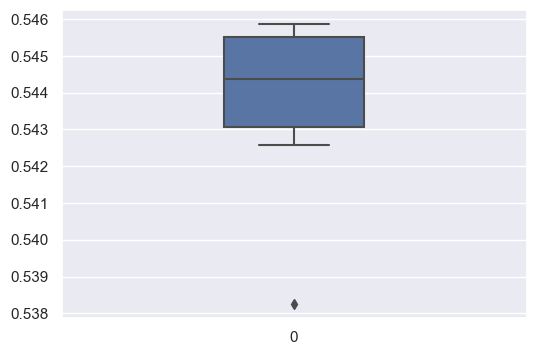

In [162]:
sb.boxplot(data=score_tree['score_tree'], width = 0.3)

Fit on all the training data

In [163]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('data',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(transformers=[('category',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['League',
                                                                    'Season',
                                                                    'GameType',
                                                                    'TeamTag',
                                                                    'Top',
                                                                    'TopChamp',
                                                                    'Jungle',
                                                                    'JungleChamp',
                                                                    'Middle',
                                                                    'MiddleChamp',
                                                                    'ADC',
                                                                    'ADCChamp',
                                                                    'Support',
                                                                    'SupportChamp',
                                                                    'ban_1',
                                                                    'ban_2',
                                                                    'ban_3',
                                                                    'ban_4',
                                                                    'ban_5',
                                                                    'Team']),
                                                                  ('nume...
                                                                    'Jungle 5',
                                                                    'Jungle 10',
                                                                    'Jungle 15',
                                                                    'Jungle 20',
                                                                    'ADC 5',
                                                                    'ADC 10',
                                                                    'ADC 15',
                                                                    'ADC 20',
                                                                    'Support 5',
                                                                    'Support '
                                                                    '10',
                                                                    'Support '
                                                                    '15',
                                                                    'Support '
                                                                    '20',
                                                                    'Middle 5',
                                                                    'Middle 10',
                                                                    'Middle 15',
                                                                    'Middle '
                                                                    '20'])])),
                                 ('filter',
                                  SelectKBest(k=20,
                                              score_func=<function chi2 at 0x139b828c0>))])),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                        min_samples_leaf=4,
                                        random_state=20220905))])

Print accuracy on the training and test data

In [164]:
DT_acc_sep = util.print_accuracies(pipe, X_train, y_train, X_test, y_test)

Train accuracy 0.547	Test accuracy 0.544


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


_Interpretation: for this very simple model, the accuracy is not great._

Show the relative importance of different features

In [165]:
feature_names = pipe.named_steps['data'].get_feature_names_out()
feature_coefs = pipe.named_steps['model'].feature_importances_
feature_df = pd.DataFrame({'Feature Name': list(feature_names), 'Importance': list(feature_coefs.flatten())})
feature_df.sort_values(by='Importance', axis=0, ascending=False, inplace=True, ignore_index=True)
feature_df['Feature Name'].replace(to_replace=['numeric__','category__'], value='', regex=True, inplace=True)
feature_df.head(20)

,Feature Name,Importance
0,Support_Bunny FuFuu,3.470027e-01
1,ban_4_Sion,3.320491e-01
2,ban_5_Bard,3.209483e-01
3,TeamTag_GV,2.994984e-16
4,ban_1_TwistedFate,0.000000e+00
5,ban_4_Karma,0.000000e+00
6,ban_3_Urgot,0.000000e+00
7,ban_3_Jayce,0.000000e+00
8,ban_2_Lissandra,0.000000e+00
9,ban_1_Varus,0.000000e+00


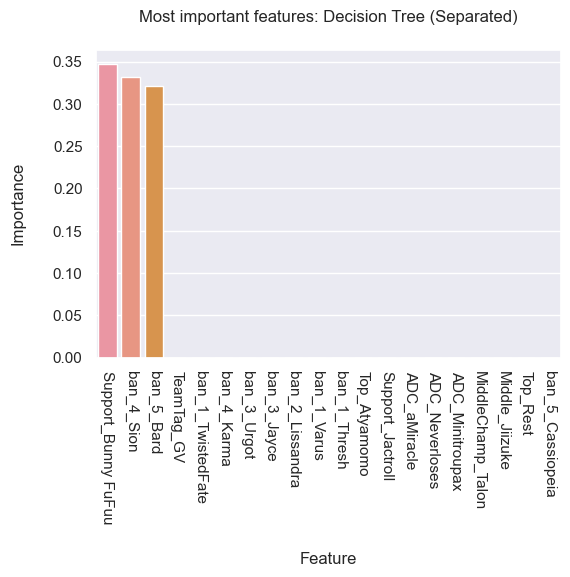

In [166]:
ax = sb.barplot(data=feature_df.iloc[0:20], x='Feature Name', y='Importance', orient='v')
ax.tick_params(axis='x', rotation=270)
ax.set_ylabel('Importance', rotation=90, labelpad=20)
ax.set_xlabel('Feature', rotation=0, labelpad=20)
ax.set_title('Most important features: Decision Tree (Separated)', pad=20)
plt.savefig('../plots/DecisionTree_Importances_Separated.pdf',dpi=300, bbox_inches = "tight")

Not including the gold difference shows us what else is the most important features. In this model, who the support is and the ban is seems to be the important features.

Plot the decision tree. Go left if the condition is true, else go right.

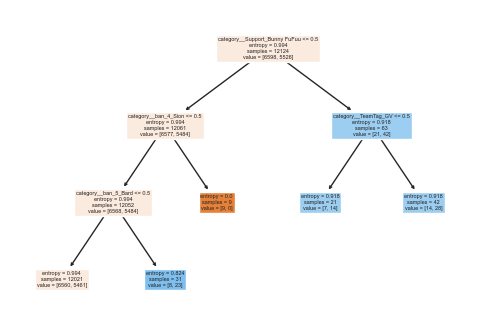

In [167]:
plot_tree(model, filled=True, feature_names = pipe.named_steps['data'].get_feature_names_out())
plt.savefig('../plots/tree_separated.pdf')

_Interpretation: the first few levels of the tree overwhelmingly split on gold difference at 10 minutes and game length._

# 4) Random forest classification, separate red/blue

Set up the model

In [168]:
RFC = RandomForestClassifier(max_depth=4, criterion='gini', random_state=20220929)

Set up the pipeline for grid search.

In [169]:
pipe_RFC = Pipeline(steps=[('data',data_pipe), ('model', RFC)])

In [170]:
param_grid = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3,4,5,6,7,8],
    'model__min_samples_leaf': [2,3,4],
}

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=skf, verbose=2)

In [171]:
grid_search.fit(X_train, y_train)

Fitting 8 folds for each of 36 candidates, totalling 288 fits
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.1s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.1s


GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=20220905, shuffle=True),
             estimator=Pipeline(steps=[('data',
                                        Pipeline(steps=[('preprocess',
                                                         ColumnTransformer(transformers=[('category',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'),
                                                                                          ['League',
                                                                                           'Season',
                                                                                           'GameType',
                                                                                           'TeamTag',
                                                                                           'Top',
                                                                                           'TopChamp',
                                                                                           'Jungle',
                                                                                           'JungleChamp',
                                                                                           'Middle',
                                                                                           'MiddleChamp',
                                                                                           'ADC',
                                                                                           'A...
                                                                                           'Middle '
                                                                                           '10',
                                                                                           'Middle '
                                                                                           '15',
                                                                                           'Middle '
                                                                                           '20'])])),
                                                        ('filter',
                                                         SelectKBest(k=20,
                                                                     score_func=<function chi2 at 0x139b828c0>))])),
                                       ('model',
                                        DecisionTreeClassifier(criterion='entropy',
                                                               max_depth=3,
                                                               min_samples_leaf=4,
                                                               random_state=20220905))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [3, 4, 5, 6, 7, 8],
                         'model__min_samples_leaf': [2, 3, 4]},
             verbose=2)

In [172]:
params = grid_search.cv_results_['params']
scores = grid_search.cv_results_['mean_test_score']
rows = [dict(param_dict, score=score) for param_dict, score in zip(params, scores)]

In [173]:
rows

[{'model__criterion': 'gini',
  'model__max_depth': 3,
  'model__min_samples_leaf': 2,
  'score': 0.5441272194501772},
 {'model__criterion': 'gini',
  'model__max_depth': 3,
  'model__min_samples_leaf': 3,
  'score': 0.5441272194501772},
 {'model__criterion': 'gini',
  'model__max_depth': 3,
  'model__min_samples_leaf': 4,
  'score': 0.5441272194501772},
 {'model__criterion': 'gini',
  'model__max_depth': 4,
  'model__min_samples_leaf': 2,
  'score': 0.5420653295540636},
 {'model__criterion': 'gini',
  'model__max_depth': 4,
  'model__min_samples_leaf': 3,
  'score': 0.5420653295540636},
 {'model__criterion': 'gini',
  'model__max_depth': 4,
  'model__min_samples_leaf': 4,
  'score': 0.5421477833799211},
 {'model__criterion': 'gini',
  'model__max_depth': 5,
  'model__min_samples_leaf': 2,
  'score': 0.5413229729965081},
 {'model__criterion': 'gini',
  'model__max_depth': 5,
  'model__min_samples_leaf': 3,
  'score': 0.5414054268223656},
 {'model__criterion': 'gini',
  'model__max_dept

In [174]:
results_df = pd.DataFrame(rows)
results_df.columns = ['Criterion', 'Max Depth', 'Min Sample Leaf','Accuracy']
results_df.head()

,Criterion,Max Depth,Min Sample Leaf,Accuracy
0,gini,3,2,0.544127
1,gini,3,3,0.544127
2,gini,3,4,0.544127
3,gini,4,2,0.542065
4,gini,4,3,0.542065


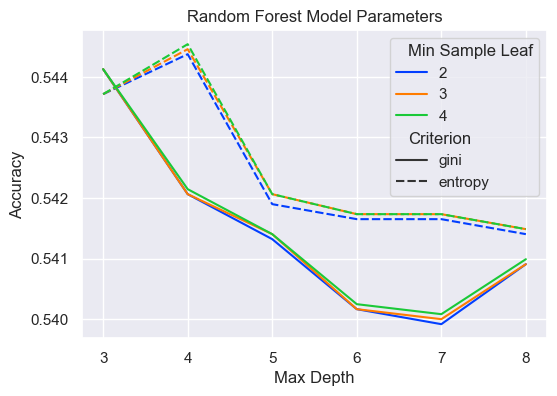

In [175]:
RFC_Grid_plot = sb.lineplot(data=results_df, x='Max Depth', y='Accuracy',
                           hue = 'Min Sample Leaf', style = 'Criterion', palette = 'bright')
RFC_Grid_plot.set(title = 'Random Forest Model Parameters')
RFC_Grid_plot.get_figure().savefig('../plots/RandomForest_GridSearch_Separated.png')

In [176]:
results_df[results_df['Accuracy'] == max(results_df['Accuracy'])]

,Criterion,Max Depth,Min Sample Leaf,Accuracy
23,entropy,4,4,0.54454


Best model parameters are Entropy as the criterion, max depth at 4, and min sample leaf at 4. The difference in accuracy compared to the other random forest model is similar to the decision tree models.

In [177]:
RFC = RandomForestClassifier(criterion='gini', max_depth=4, min_samples_leaf = 4,random_state=20220929)

In [178]:
pipe_RFC = Pipeline(steps=[('data',data_pipe), ('model', RFC)])

Compute cross-validation results for the random forest

In [179]:
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=20220905)

scores = cross_val_score(pipe_RFC, X_train, y_train, cv=skf, scoring='accuracy', verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .................................................... total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 8, 9, 10, 12, 13, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.6s finished


Create a data frame from the scores

In [180]:
score_RFC = pd.DataFrame({'score_RFC': scores})
score_RFC

,score_RFC
0,0.544855
1,0.546174
2,0.543536
3,0.538918
4,0.544554
5,0.539934
6,0.540594
7,0.539274


Plot accuracy for each cross-validation run.

<AxesSubplot: >

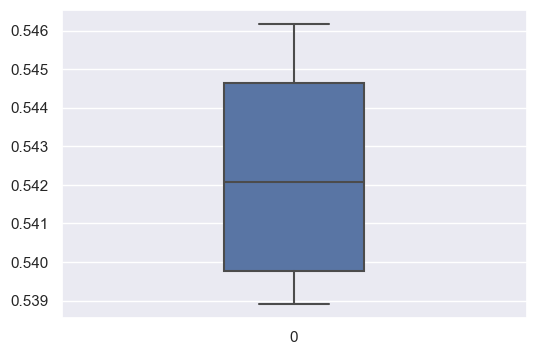

In [181]:
sb.boxplot(data=score_RFC['score_RFC'], width = 0.3)

Fit on all the training data

In [182]:
pipe_RFC.fit(X_train,y_train)

Pipeline(steps=[('data',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(transformers=[('category',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['League',
                                                                    'Season',
                                                                    'GameType',
                                                                    'TeamTag',
                                                                    'Top',
                                                                    'TopChamp',
                                                                    'Jungle',
                                                                    'JungleChamp',
                                                                    'Middle',
                                                                    'MiddleChamp',
                                                                    'ADC',
                                                                    'ADCChamp',
                                                                    'Support',
                                                                    'SupportChamp',
                                                                    'ban_1',
                                                                    'ban_2',
                                                                    'ban_3',
                                                                    'ban_4',
                                                                    'ban_5',
                                                                    'Team']),
                                                                  ('nume...
                                                                    'Top 15',
                                                                    'Top 20',
                                                                    'Jungle 5',
                                                                    'Jungle 10',
                                                                    'Jungle 15',
                                                                    'Jungle 20',
                                                                    'ADC 5',
                                                                    'ADC 10',
                                                                    'ADC 15',
                                                                    'ADC 20',
                                                                    'Support 5',
                                                                    'Support '
                                                                    '10',
                                                                    'Support '
                                                                    '15',
                                                                    'Support '
                                                                    '20',
                                                                    'Middle 5',
                                                                    'Middle 10',
                                                                    'Middle 15',
                                                                    'Middle '
                                                                    '20'])])),
                                 ('filter',
                                  SelectKBest(k=20,
                                              score_func=<function chi2 at 0x139b828c0>))])),
                ('model',
                 RandomForestClassifier(max_depth=4,

Print accuracy on the training and test data

In [183]:
RFC_acc_sep = util.print_accuracies(pipe_RFC, X_train, y_train, X_test, y_test)

Train accuracy 0.550	Test accuracy 0.543


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [184]:
feature_names = pipe_RFC.named_steps['data'].get_feature_names_out()
feature_coefs = pipe_RFC.named_steps['model'].feature_importances_
feature_df = pd.DataFrame({'Feature Name': list(feature_names), 'Importance': list(feature_coefs.flatten())})
feature_df.sort_values(by='Importance', axis=0, ascending=False, inplace=True, ignore_index=True)
feature_df['Feature Name'].replace(to_replace=['numeric__','category__'], value='', regex=True, inplace=True)
feature_df.head(20)

,Feature Name,Importance
0,Support_Bunny FuFuu,0.111027
1,ban_2_Lissandra,0.096500
2,ban_5_Bard,0.090072
3,Top_Atyamomo,0.076472
4,ban_1_Thresh,0.072856
5,MiddleChamp_Talon,0.063123
6,Top_Rest,0.054123
7,ban_4_Karma,0.050810
8,ban_3_Jayce,0.049946
9,ban_1_Varus,0.049634


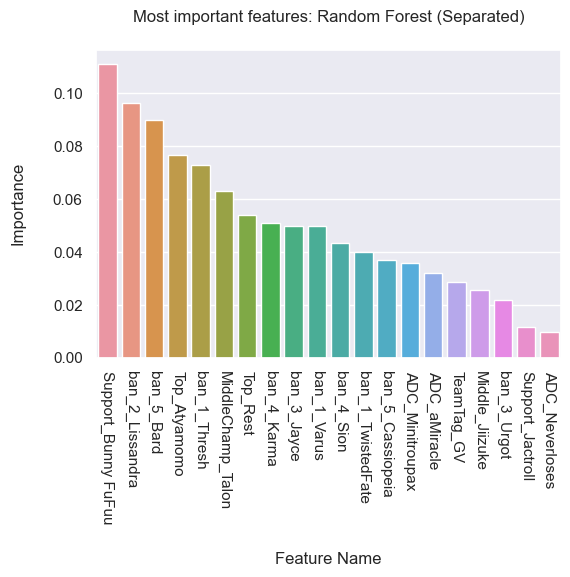

In [188]:
ax = sb.barplot(data=feature_df.iloc[0:20], x='Feature Name', y='Importance', orient='v')
ax.tick_params(axis='x', rotation=270)
ax.set_ylabel('Importance', rotation=90, labelpad=20)
ax.set_xlabel('Feature Name', rotation=0, labelpad=20)
ax.set_title('Most important features: Random Forest (Separated)', pad=20)
plt.savefig('../plots/RandomForest_importances_separated.pdf',dpi=300, bbox_inches = "tight")

Support being Bunny FuFuu is once again an important feature, while bans play an important role too.

# Accuracies

Creating a bar plot to compare the accuracies of the different models to compare them.

In [186]:
acc_df = pd.DataFrame([DT_acc_cmb[0],RFC_acc_cmb[0],
                       DT_acc_sep[0],RFC_acc_sep[0],
                       DT_acc_cmb[1],RFC_acc_cmb[1],
                       DT_acc_sep[1],RFC_acc_sep[1]],
                       columns = ['Accuracy'])
acc_df['Type'] = ['Train','Train','Train','Train',
                  'Test','Test','Test','Test',]
acc_df['Model'] = ['DT_cmb','RFC_cmb','DT_sep','RFC_sep',
                  'DT_cmb','RFC_cmb','DT_sep','RFC_sep']
acc_df

,Accuracy,Type,Model
0,0.766249,Train,DT_cmb
1,0.768228,Train,RFC_cmb
2,0.547179,Train,DT_sep
3,0.550396,Train,RFC_sep
4,0.778364,Test,DT_cmb
5,0.781662,Test,RFC_cmb
6,0.544195,Test,DT_sep
7,0.542546,Test,RFC_sep


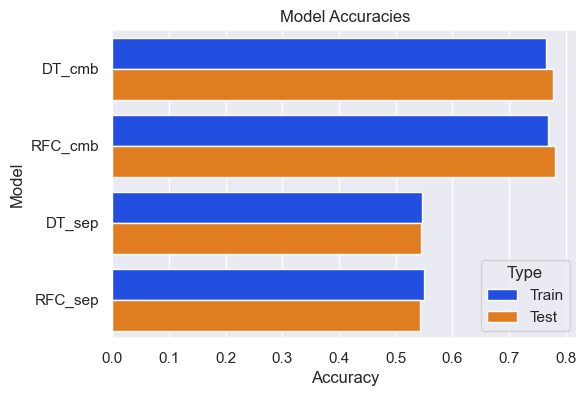

In [187]:
barplot = sb.barplot(data = acc_df, y = 'Model', x = 'Accuracy', hue = 'Type', palette = 'bright')
barplot.set(title = 'Model Accuracies')

barplot.get_figure().savefig('../plots/ACC_DT_RFC_sep_combined_train_test.png', dpi=300, bbox_inches='tight')

Gold difference seems to have a huge impact on the each model's performance. The combined data set (models with cmb) contains the gold difference while the seperated models (models with sep) do not contain gold diff.